<a href="https://colab.research.google.com/github/sayanbanerjee32/TASI_ERAv2_S9/blob/main/S9_stride2_dilated_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required packages including local files

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np

#import from local modules
from cifar10_dataset import Cifar10Dataset
from train import train, test, checkpoint, resume
from utils import get_device, plot_accuracy_losses, plot_top_loss
from model_stride2_dilated_pooling import Net

# Check if GPU available

In [ ]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Visualising Train data

# Dataset and Creating Train/Test Split

In [ ]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [ ]:
# train data shape
print(train_data_raw.data.shape)
# train data mean
print(train_data_raw.data.mean(axis=(0,1,2))/255)
# train data standard deviation
print(train_data_raw.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader_raw = torch.utils.data.DataLoader(train_data_raw, **dataloader_args)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


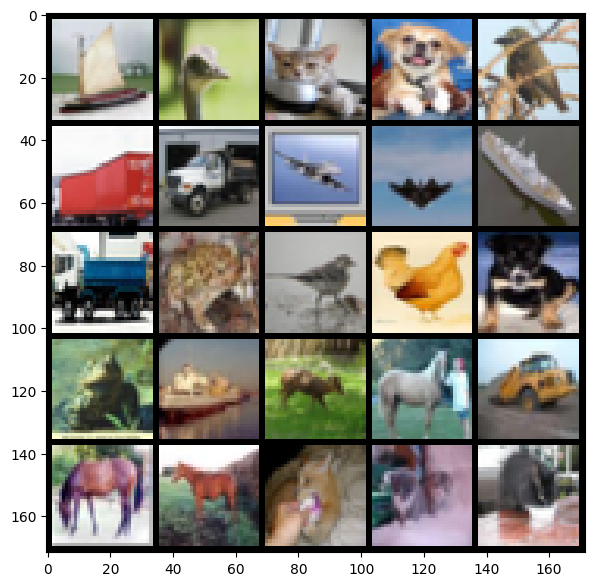

In [ ]:
dataiter = iter(train_loader_raw)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [ ]:
# how labels look like
print(' '.join(f'{class_labels[labels[j]]:5s}' for j in range(len(labels[:25]))))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat  


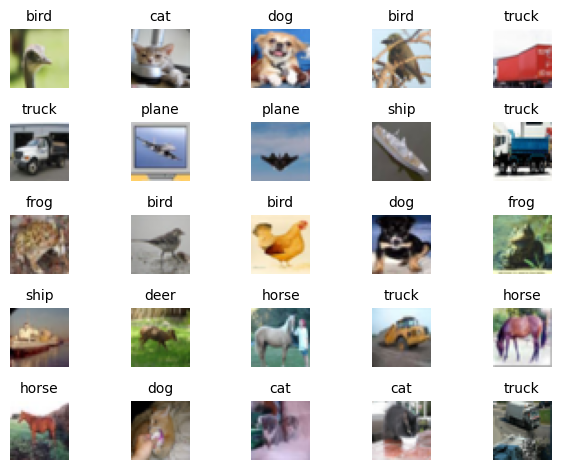

In [ ]:
figure = plt.figure()
rows, cols = 5, 5
for index in range(1, cols * rows  + 1):
    plt.subplot(rows, cols, index)
    plt.title(class_labels[labels[index]],fontsize = 10)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
figure.tight_layout()
plt.show()

# Train and Test transformations

In [ ]:
# Train Phase transformations
train_transforms = A.Compose([
                                # A.Compose([
                                #     A.PadIfNeeded (min_height=36, min_width=36, p = 1.0),
                                #     A.RandomCrop(p=1, height=32, width=32),
                                # ], p = 0.5),
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(p=0.5),
                                # A.ColorJitter(p = 0.5),
                                A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                                # A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                #                 fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None, p=0.5),
                                A.Compose([A.PadIfNeeded (min_height=64, min_width=64, p = 1.0),
                                            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                                fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None, p=1),
                                           A.CenterCrop(height=32, width=32, p=1),
                                ], p = 1),
                                ToTensorV2(),
                                ])

# Test Phase transformations
test_transforms = A.Compose([
                            A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                            ToTensorV2(),
                            ])

# Dataset and Creating Train/Test Split

In [ ]:
train_data = Cifar10Dataset(transform=train_transforms)
test_data = Cifar10Dataset(train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data

Dataset Cifar10Dataset
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose([
             HorizontalFlip(always_apply=False, p=0.5),
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
             Normalize(always_apply=False, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.262), max_pixel_value=255.0),
             Compose([
               PadIfNeeded(always_apply=False, p=1.0, min_height=64, min_width=64, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=None, mask_value=None),
               CoarseDropout(always_apply=False, p=1, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=[0.4914, 0.4822, 0.4465], m

# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

### Augmented data visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


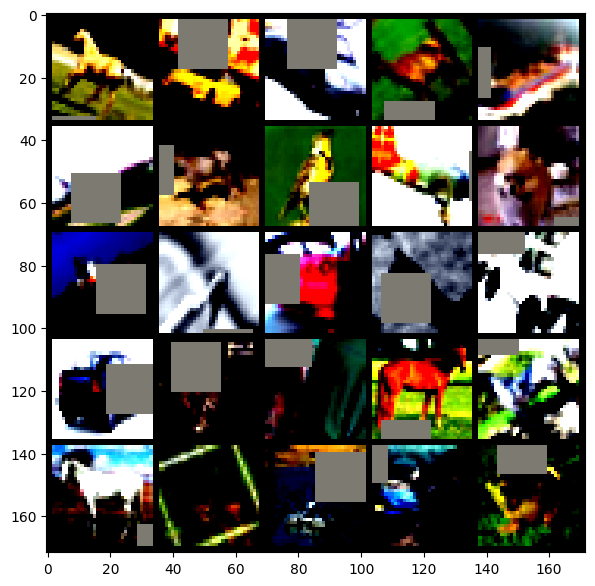

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

# Training

In [ ]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
             ReLU-14           [-1, 64,

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [ ]:
current_learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=current_learning_rate,
                      momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 3,
                                                 verbose = True)
criterion = F.nll_loss
num_epochs = 100
early_stopping_patience = 10
best_test_loss = np.inf
best_epoch = -1

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)
    if current_learning_rate != scheduler.get_last_lr()[0]:
        current_learning_rate = scheduler.get_last_lr()[0]
        print(f'Learning rate updated to: {current_learning_rate}')
        best_epoch = epoch
        # break

    # early stopping
    if tst_loss < best_test_loss:
        best_test_loss = tst_loss
        best_epoch = epoch
        checkpoint(model, "best_model.pth")
    elif epoch - best_epoch > early_stopping_patience:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop

resume(model, "best_model.pth")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=1.7911 Batch_id=390 Accuracy=32.15: 100%|██████████| 391/391 [00:22<00:00, 17.02it/s]


Test set: Average loss: 1.5902, Accuracy: 4184/10000 (41.84%)

Epoch 2


Train: Loss=1.5973 Batch_id=390 Accuracy=43.17: 100%|██████████| 391/391 [00:21<00:00, 17.87it/s]


Test set: Average loss: 1.3667, Accuracy: 4965/10000 (49.65%)

Epoch 3


Train: Loss=1.2592 Batch_id=390 Accuracy=48.92: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]


Test set: Average loss: 1.2146, Accuracy: 5660/10000 (56.60%)

Epoch 4


Train: Loss=1.2862 Batch_id=390 Accuracy=53.47: 100%|██████████| 391/391 [00:17<00:00, 22.32it/s]


Test set: Average loss: 1.0779, Accuracy: 6129/10000 (61.29%)

Epoch 5


Train: Loss=1.3171 Batch_id=390 Accuracy=56.44: 100%|██████████| 391/391 [00:18<00:00, 21.56it/s]


Test set: Average loss: 1.0428, Accuracy: 6401/10000 (64.01%)

Epoch 6


Train: Loss=1.0974 Batch_id=390 Accuracy=59.48: 100%|██████████| 391/391 [00:17<00:00, 22.45it/s]


Test set: Average loss: 0.9310, Accuracy: 6707/10000 (67.07%)

Epoch 7


Train: Loss=1.0575 Batch_id=390 Accuracy=62.34: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s]


Test set: Average loss: 0.8316, Accuracy: 7130/10000 (71.30%)

Epoch 8


Train: Loss=1.0481 Batch_id=390 Accuracy=64.13: 100%|██████████| 391/391 [00:18<00:00, 21.67it/s]


Test set: Average loss: 0.7845, Accuracy: 7268/10000 (72.68%)

Epoch 9


Train: Loss=1.1366 Batch_id=390 Accuracy=65.35: 100%|██████████| 391/391 [00:18<00:00, 21.66it/s]


Test set: Average loss: 0.7562, Accuracy: 7413/10000 (74.13%)

Epoch 10


Train: Loss=0.9660 Batch_id=390 Accuracy=66.80: 100%|██████████| 391/391 [00:17<00:00, 22.38it/s]


Test set: Average loss: 0.7249, Accuracy: 7519/10000 (75.19%)

Epoch 11


Train: Loss=0.9963 Batch_id=390 Accuracy=67.87: 100%|██████████| 391/391 [00:19<00:00, 20.14it/s]


Test set: Average loss: 0.7072, Accuracy: 7543/10000 (75.43%)

Epoch 12


Train: Loss=0.7341 Batch_id=390 Accuracy=68.68: 100%|██████████| 391/391 [00:17<00:00, 22.27it/s]


Test set: Average loss: 0.6963, Accuracy: 7691/10000 (76.91%)

Epoch 13


Train: Loss=0.9237 Batch_id=390 Accuracy=69.85: 100%|██████████| 391/391 [00:18<00:00, 21.34it/s]


Test set: Average loss: 0.6511, Accuracy: 7859/10000 (78.59%)

Epoch 14


Train: Loss=0.9782 Batch_id=390 Accuracy=70.59: 100%|██████████| 391/391 [00:17<00:00, 22.38it/s]


Test set: Average loss: 0.6595, Accuracy: 7800/10000 (78.00%)

Epoch 15


Train: Loss=0.6595 Batch_id=390 Accuracy=71.29: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s]


Test set: Average loss: 0.6316, Accuracy: 7865/10000 (78.65%)

Epoch 16


Train: Loss=1.0874 Batch_id=390 Accuracy=71.99: 100%|██████████| 391/391 [00:17<00:00, 22.27it/s]


Test set: Average loss: 0.6116, Accuracy: 7918/10000 (79.18%)

Epoch 17


Train: Loss=0.7346 Batch_id=390 Accuracy=72.42: 100%|██████████| 391/391 [00:18<00:00, 21.13it/s]


Test set: Average loss: 0.6008, Accuracy: 7985/10000 (79.85%)

Epoch 18


Train: Loss=0.8701 Batch_id=390 Accuracy=72.82: 100%|██████████| 391/391 [00:17<00:00, 22.35it/s]


Test set: Average loss: 0.5899, Accuracy: 8035/10000 (80.35%)

Epoch 19


Train: Loss=0.8040 Batch_id=390 Accuracy=73.45: 100%|██████████| 391/391 [00:17<00:00, 21.78it/s]


Test set: Average loss: 0.5847, Accuracy: 7986/10000 (79.86%)

Epoch 20


Train: Loss=0.7620 Batch_id=390 Accuracy=74.32: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]


Test set: Average loss: 0.5532, Accuracy: 8136/10000 (81.36%)

Epoch 21


Train: Loss=0.6560 Batch_id=390 Accuracy=74.22: 100%|██████████| 391/391 [00:20<00:00, 18.76it/s]


Test set: Average loss: 0.5818, Accuracy: 8007/10000 (80.07%)

Epoch 22


Train: Loss=0.7813 Batch_id=390 Accuracy=74.75: 100%|██████████| 391/391 [00:19<00:00, 20.36it/s]


Test set: Average loss: 0.5319, Accuracy: 8190/10000 (81.90%)

Epoch 23


Train: Loss=0.7078 Batch_id=390 Accuracy=75.05: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]


Test set: Average loss: 0.5198, Accuracy: 8244/10000 (82.44%)

Epoch 24


Train: Loss=0.7402 Batch_id=390 Accuracy=75.46: 100%|██████████| 391/391 [00:18<00:00, 21.70it/s]


Test set: Average loss: 0.5185, Accuracy: 8265/10000 (82.65%)

Epoch 25


Train: Loss=0.5703 Batch_id=390 Accuracy=75.98: 100%|██████████| 391/391 [00:19<00:00, 20.19it/s]


Test set: Average loss: 0.5121, Accuracy: 8251/10000 (82.51%)

Epoch 26


Train: Loss=0.7919 Batch_id=390 Accuracy=75.89: 100%|██████████| 391/391 [00:17<00:00, 21.80it/s]


Test set: Average loss: 0.5091, Accuracy: 8279/10000 (82.79%)

Epoch 27


Train: Loss=0.7607 Batch_id=390 Accuracy=76.46: 100%|██████████| 391/391 [00:18<00:00, 21.09it/s]


Test set: Average loss: 0.4786, Accuracy: 8394/10000 (83.94%)

Epoch 28


Train: Loss=0.6698 Batch_id=390 Accuracy=76.79: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]


Test set: Average loss: 0.4884, Accuracy: 8318/10000 (83.18%)

Epoch 29


Train: Loss=0.8787 Batch_id=390 Accuracy=76.58: 100%|██████████| 391/391 [00:18<00:00, 21.21it/s]


Test set: Average loss: 0.4731, Accuracy: 8386/10000 (83.86%)

Epoch 30


Train: Loss=0.5952 Batch_id=390 Accuracy=77.27: 100%|██████████| 391/391 [00:19<00:00, 19.60it/s]


Test set: Average loss: 0.5031, Accuracy: 8298/10000 (82.98%)

Epoch 31


Train: Loss=0.6145 Batch_id=390 Accuracy=77.16: 100%|██████████| 391/391 [00:18<00:00, 21.48it/s]


Test set: Average loss: 0.4851, Accuracy: 8386/10000 (83.86%)

Epoch 32


Train: Loss=0.6397 Batch_id=390 Accuracy=77.77: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s]


Test set: Average loss: 0.4642, Accuracy: 8446/10000 (84.46%)

Epoch 33


Train: Loss=0.5157 Batch_id=390 Accuracy=77.68: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s]


Test set: Average loss: 0.4719, Accuracy: 8431/10000 (84.31%)

Epoch 34


Train: Loss=0.5074 Batch_id=390 Accuracy=78.13: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s]


Test set: Average loss: 0.4629, Accuracy: 8427/10000 (84.27%)

Epoch 35


Train: Loss=0.8090 Batch_id=390 Accuracy=78.20: 100%|██████████| 391/391 [00:17<00:00, 21.85it/s]


Test set: Average loss: 0.4654, Accuracy: 8417/10000 (84.17%)

Epoch 36


Train: Loss=0.5221 Batch_id=390 Accuracy=78.60: 100%|██████████| 391/391 [00:19<00:00, 20.41it/s]


Test set: Average loss: 0.4714, Accuracy: 8380/10000 (83.80%)

Epoch 37


Train: Loss=0.9214 Batch_id=390 Accuracy=78.64: 100%|██████████| 391/391 [00:18<00:00, 21.52it/s]


Test set: Average loss: 0.4601, Accuracy: 8454/10000 (84.54%)

Epoch 38


Train: Loss=0.5068 Batch_id=390 Accuracy=79.03: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]


Test set: Average loss: 0.4439, Accuracy: 8470/10000 (84.70%)

Epoch 39


Train: Loss=0.5640 Batch_id=390 Accuracy=78.69: 100%|██████████| 391/391 [00:17<00:00, 21.98it/s]


Test set: Average loss: 0.4278, Accuracy: 8552/10000 (85.52%)

Epoch 40


Train: Loss=0.5788 Batch_id=390 Accuracy=79.15: 100%|██████████| 391/391 [00:19<00:00, 19.76it/s]


Test set: Average loss: 0.4418, Accuracy: 8481/10000 (84.81%)

Epoch 41


Train: Loss=0.6850 Batch_id=390 Accuracy=79.25: 100%|██████████| 391/391 [00:18<00:00, 21.72it/s]


Test set: Average loss: 0.4268, Accuracy: 8555/10000 (85.55%)

Epoch 42


Train: Loss=0.6639 Batch_id=390 Accuracy=79.40: 100%|██████████| 391/391 [00:18<00:00, 20.59it/s]


Test set: Average loss: 0.4330, Accuracy: 8525/10000 (85.25%)

Epoch 43


Train: Loss=0.4740 Batch_id=390 Accuracy=79.44: 100%|██████████| 391/391 [00:17<00:00, 21.88it/s]


Test set: Average loss: 0.4557, Accuracy: 8430/10000 (84.30%)

Epoch 44


Train: Loss=0.6540 Batch_id=390 Accuracy=79.94: 100%|██████████| 391/391 [00:19<00:00, 20.41it/s]


Test set: Average loss: 0.4107, Accuracy: 8602/10000 (86.02%)

Epoch 45


Train: Loss=0.7440 Batch_id=390 Accuracy=80.16: 100%|██████████| 391/391 [00:18<00:00, 21.67it/s]


Test set: Average loss: 0.4171, Accuracy: 8611/10000 (86.11%)

Epoch 46


Train: Loss=0.6133 Batch_id=390 Accuracy=80.25: 100%|██████████| 391/391 [00:18<00:00, 21.04it/s]


Test set: Average loss: 0.4135, Accuracy: 8586/10000 (85.86%)

Epoch 47


Train: Loss=0.5694 Batch_id=390 Accuracy=79.73: 100%|██████████| 391/391 [00:17<00:00, 22.06it/s]


Test set: Average loss: 0.4113, Accuracy: 8607/10000 (86.07%)

Epoch 48


Train: Loss=0.5095 Batch_id=390 Accuracy=80.20: 100%|██████████| 391/391 [00:18<00:00, 21.19it/s]


Test set: Average loss: 0.4073, Accuracy: 8629/10000 (86.29%)

Epoch 49


Train: Loss=0.6266 Batch_id=390 Accuracy=80.31: 100%|██████████| 391/391 [00:18<00:00, 20.75it/s]


Test set: Average loss: 0.4176, Accuracy: 8564/10000 (85.64%)

Epoch 50


Train: Loss=0.4546 Batch_id=390 Accuracy=80.51: 100%|██████████| 391/391 [00:18<00:00, 21.06it/s]


Test set: Average loss: 0.4115, Accuracy: 8617/10000 (86.17%)

Epoch 51


Train: Loss=0.6336 Batch_id=390 Accuracy=80.55: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]


Test set: Average loss: 0.4112, Accuracy: 8597/10000 (85.97%)

Epoch 52


Train: Loss=0.7971 Batch_id=390 Accuracy=80.49: 100%|██████████| 391/391 [00:18<00:00, 21.09it/s]


Test set: Average loss: 0.4131, Accuracy: 8588/10000 (85.88%)

Learning rate updated to: 0.010000000000000002
Epoch 53


Train: Loss=0.4532 Batch_id=390 Accuracy=82.45: 100%|██████████| 391/391 [00:17<00:00, 21.95it/s]


Test set: Average loss: 0.3688, Accuracy: 8747/10000 (87.47%)

Epoch 54


Train: Loss=0.2456 Batch_id=390 Accuracy=82.56: 100%|██████████| 391/391 [00:18<00:00, 21.06it/s]


Test set: Average loss: 0.3655, Accuracy: 8752/10000 (87.52%)

Epoch 55


Train: Loss=0.4911 Batch_id=390 Accuracy=82.80: 100%|██████████| 391/391 [00:17<00:00, 22.05it/s]


Test set: Average loss: 0.3623, Accuracy: 8742/10000 (87.42%)

Epoch 56


Train: Loss=0.5798 Batch_id=390 Accuracy=82.92: 100%|██████████| 391/391 [00:18<00:00, 21.08it/s]


Test set: Average loss: 0.3592, Accuracy: 8752/10000 (87.52%)

Epoch 57


Train: Loss=0.6246 Batch_id=390 Accuracy=83.19: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]


Test set: Average loss: 0.3582, Accuracy: 8757/10000 (87.57%)

Epoch 58


Train: Loss=0.4729 Batch_id=390 Accuracy=83.02: 100%|██████████| 391/391 [00:18<00:00, 21.10it/s]


Test set: Average loss: 0.3553, Accuracy: 8782/10000 (87.82%)

Epoch 59


Train: Loss=0.5053 Batch_id=390 Accuracy=82.90: 100%|██████████| 391/391 [00:19<00:00, 20.07it/s]


Test set: Average loss: 0.3572, Accuracy: 8775/10000 (87.75%)

Epoch 60


Train: Loss=0.5460 Batch_id=390 Accuracy=83.31: 100%|██████████| 391/391 [00:18<00:00, 20.78it/s]


Test set: Average loss: 0.3559, Accuracy: 8761/10000 (87.61%)

Epoch 61


Train: Loss=0.5042 Batch_id=390 Accuracy=83.27: 100%|██████████| 391/391 [00:17<00:00, 21.75it/s]


Test set: Average loss: 0.3540, Accuracy: 8786/10000 (87.86%)

Epoch 62


Train: Loss=0.4120 Batch_id=390 Accuracy=83.18: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]


Test set: Average loss: 0.3548, Accuracy: 8760/10000 (87.60%)

Epoch 63


Train: Loss=0.4424 Batch_id=390 Accuracy=83.25: 100%|██████████| 391/391 [00:17<00:00, 21.75it/s]


Test set: Average loss: 0.3549, Accuracy: 8774/10000 (87.74%)

Epoch 64


Train: Loss=0.5462 Batch_id=390 Accuracy=83.37: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]


Test set: Average loss: 0.3526, Accuracy: 8770/10000 (87.70%)

Epoch 65


Train: Loss=0.5114 Batch_id=390 Accuracy=83.51: 100%|██████████| 391/391 [00:17<00:00, 21.89it/s]


Test set: Average loss: 0.3550, Accuracy: 8769/10000 (87.69%)

Epoch 66


Train: Loss=0.4571 Batch_id=390 Accuracy=83.45: 100%|██████████| 391/391 [00:18<00:00, 20.78it/s]


Test set: Average loss: 0.3518, Accuracy: 8787/10000 (87.87%)

Epoch 67


Train: Loss=0.3450 Batch_id=390 Accuracy=83.70: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]


Test set: Average loss: 0.3542, Accuracy: 8778/10000 (87.78%)

Epoch 68


Train: Loss=0.6434 Batch_id=390 Accuracy=83.77: 100%|██████████| 391/391 [00:19<00:00, 20.07it/s]


Test set: Average loss: 0.3476, Accuracy: 8789/10000 (87.89%)

Epoch 69


Train: Loss=0.4280 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]


Test set: Average loss: 0.3526, Accuracy: 8759/10000 (87.59%)

Epoch 70


Train: Loss=0.4421 Batch_id=390 Accuracy=83.39: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s]


Test set: Average loss: 0.3495, Accuracy: 8785/10000 (87.85%)

Epoch 71


Train: Loss=0.6341 Batch_id=390 Accuracy=83.52: 100%|██████████| 391/391 [00:17<00:00, 22.25it/s]


Test set: Average loss: 0.3506, Accuracy: 8786/10000 (87.86%)

Epoch 72


Train: Loss=0.5993 Batch_id=390 Accuracy=83.58: 100%|██████████| 391/391 [00:18<00:00, 21.11it/s]


Test set: Average loss: 0.3528, Accuracy: 8777/10000 (87.77%)

Learning rate updated to: 0.0010000000000000002
Epoch 73


Train: Loss=0.5724 Batch_id=390 Accuracy=83.60: 100%|██████████| 391/391 [00:17<00:00, 21.99it/s]


Test set: Average loss: 0.3497, Accuracy: 8779/10000 (87.79%)

Epoch 74


Train: Loss=0.3915 Batch_id=390 Accuracy=83.82: 100%|██████████| 391/391 [00:18<00:00, 21.05it/s]


Test set: Average loss: 0.3493, Accuracy: 8778/10000 (87.78%)

Epoch 75


Train: Loss=0.4196 Batch_id=390 Accuracy=83.67: 100%|██████████| 391/391 [00:18<00:00, 21.65it/s]


Test set: Average loss: 0.3473, Accuracy: 8784/10000 (87.84%)

Epoch 76


Train: Loss=0.4036 Batch_id=390 Accuracy=83.97: 100%|██████████| 391/391 [00:18<00:00, 21.09it/s]


Test set: Average loss: 0.3489, Accuracy: 8794/10000 (87.94%)

Epoch 77


Train: Loss=0.4107 Batch_id=390 Accuracy=83.84: 100%|██████████| 391/391 [00:18<00:00, 21.71it/s]


Test set: Average loss: 0.3477, Accuracy: 8791/10000 (87.91%)

Epoch 78


Train: Loss=0.4351 Batch_id=390 Accuracy=83.78: 100%|██████████| 391/391 [00:20<00:00, 19.49it/s]


Test set: Average loss: 0.3480, Accuracy: 8796/10000 (87.96%)

Epoch 79


Train: Loss=0.4637 Batch_id=390 Accuracy=83.89: 100%|██████████| 391/391 [00:17<00:00, 21.85it/s]


Test set: Average loss: 0.3472, Accuracy: 8795/10000 (87.95%)

Epoch 80


Train: Loss=0.4210 Batch_id=390 Accuracy=84.02: 100%|██████████| 391/391 [00:18<00:00, 20.76it/s]


Test set: Average loss: 0.3476, Accuracy: 8801/10000 (88.01%)

Epoch 81


Train: Loss=0.5571 Batch_id=390 Accuracy=83.71: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s]


Test set: Average loss: 0.3471, Accuracy: 8799/10000 (87.99%)

Epoch 82


Train: Loss=0.4017 Batch_id=390 Accuracy=84.07: 100%|██████████| 391/391 [00:18<00:00, 20.63it/s]


Test set: Average loss: 0.3477, Accuracy: 8798/10000 (87.98%)

Epoch 83


Train: Loss=0.5082 Batch_id=390 Accuracy=83.86: 100%|██████████| 391/391 [00:17<00:00, 21.86it/s]


Test set: Average loss: 0.3485, Accuracy: 8805/10000 (88.05%)

Epoch 84


Train: Loss=0.4299 Batch_id=390 Accuracy=84.00: 100%|██████████| 391/391 [00:19<00:00, 20.40it/s]


Test set: Average loss: 0.3465, Accuracy: 8790/10000 (87.90%)

Epoch 85


Train: Loss=0.5330 Batch_id=390 Accuracy=83.89: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]


Test set: Average loss: 0.3468, Accuracy: 8793/10000 (87.93%)

Epoch 86


Train: Loss=0.4428 Batch_id=390 Accuracy=83.87: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s]


Test set: Average loss: 0.3463, Accuracy: 8807/10000 (88.07%)

Epoch 87


Train: Loss=0.4812 Batch_id=390 Accuracy=83.93: 100%|██████████| 391/391 [00:18<00:00, 21.46it/s]


Test set: Average loss: 0.3487, Accuracy: 8780/10000 (87.80%)

Epoch 88


Train: Loss=0.4693 Batch_id=390 Accuracy=84.03: 100%|██████████| 391/391 [00:19<00:00, 19.79it/s]


Test set: Average loss: 0.3455, Accuracy: 8795/10000 (87.95%)

Epoch 89


Train: Loss=0.4129 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [00:17<00:00, 21.75it/s]


Test set: Average loss: 0.3463, Accuracy: 8793/10000 (87.93%)

Epoch 90


Train: Loss=0.5428 Batch_id=390 Accuracy=84.00: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]


Test set: Average loss: 0.3481, Accuracy: 8794/10000 (87.94%)

Epoch 91


Train: Loss=0.3906 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [00:18<00:00, 21.69it/s]


Test set: Average loss: 0.3455, Accuracy: 8795/10000 (87.95%)

Epoch 92


Train: Loss=0.5935 Batch_id=390 Accuracy=83.88: 100%|██████████| 391/391 [00:18<00:00, 20.59it/s]


Test set: Average loss: 0.3463, Accuracy: 8800/10000 (88.00%)

Learning rate updated to: 0.00010000000000000003
Epoch 93


Train: Loss=0.4960 Batch_id=390 Accuracy=83.84: 100%|██████████| 391/391 [00:18<00:00, 21.40it/s]


Test set: Average loss: 0.3456, Accuracy: 8793/10000 (87.93%)

Epoch 94


Train: Loss=0.4878 Batch_id=390 Accuracy=84.18: 100%|██████████| 391/391 [00:18<00:00, 20.63it/s]


Test set: Average loss: 0.3469, Accuracy: 8797/10000 (87.97%)

Epoch 95


Train: Loss=0.4584 Batch_id=390 Accuracy=83.87: 100%|██████████| 391/391 [00:18<00:00, 21.70it/s]


Test set: Average loss: 0.3432, Accuracy: 8810/10000 (88.10%)

Epoch 96


Train: Loss=0.2734 Batch_id=390 Accuracy=83.93: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]


Test set: Average loss: 0.3444, Accuracy: 8803/10000 (88.03%)

Epoch 97


Train: Loss=0.3726 Batch_id=390 Accuracy=83.89: 100%|██████████| 391/391 [00:18<00:00, 20.60it/s]


Test set: Average loss: 0.3472, Accuracy: 8800/10000 (88.00%)

Epoch 98


Train: Loss=0.4005 Batch_id=390 Accuracy=84.04: 100%|██████████| 391/391 [00:18<00:00, 21.03it/s]


Test set: Average loss: 0.3467, Accuracy: 8798/10000 (87.98%)

Epoch 99


Train: Loss=0.3550 Batch_id=390 Accuracy=83.73: 100%|██████████| 391/391 [00:18<00:00, 21.53it/s]


Test set: Average loss: 0.3460, Accuracy: 8799/10000 (87.99%)

Epoch 100


Train: Loss=0.3821 Batch_id=390 Accuracy=84.23: 100%|██████████| 391/391 [00:18<00:00, 21.57it/s]


Test set: Average loss: 0.3441, Accuracy: 8806/10000 (88.06%)



In [ ]:
# final learning rate
scheduler.get_last_lr()

[0.00010000000000000003]

## Visualise training and test losses and accuracies

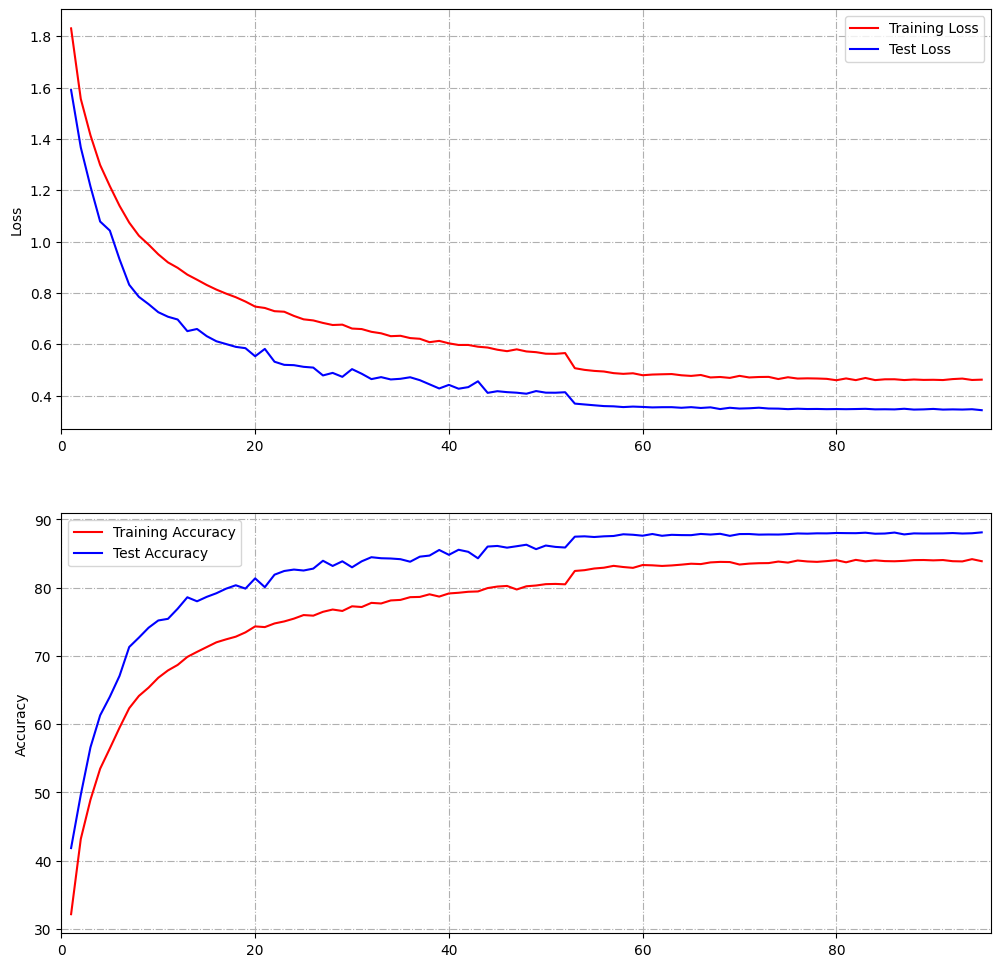

In [ ]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, best_epoch)

## Error analysis

total wrong predictions: 1190


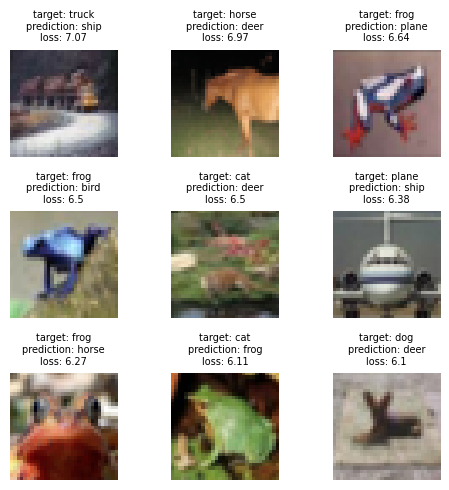

In [ ]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=3, img_cols = 3)

In [ ]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
33,dog,cat,1.398769,137
18,cat,dog,1.382475,71
2,bird,deer,1.674154,45
15,cat,bird,1.826266,44
41,frog,cat,1.640678,41
...,...,...,...,...
43,frog,dog,1.792746,2
40,frog,car,1.886706,2
10,car,deer,3.309170,2
9,car,cat,2.560753,2
